# Facial Emotion Recognition | VGG16 Model - FER2013 Dataset

![](https://www.researchgate.net/publication/349055345/figure/fig3/AS:987834383085568@1612529478973/FER-2013-sample-images-for-facial-emotion-recognition.jpg)

* Fer2013 dataset is a common dataset used for facial expression recognition. The dataset contains 35,887 grayscale facial images containing 7 different emotions (anger, disgust, fear, happiness, neutral, sad, and surprise).

* VGG19 is a deep learning model known as the Convolutional Neural Network (CNN) architecture. The VGG19 model has 19 layers and consists of 16 layers of convolutional layers and 3 layers of fully connected layers. Convolutional layers extract features from the input image using filters.

* Transfer learning can be performed using the pre-trained weights of the VGG19 model. Transfer learning is the use of the weights of a pre-trained model to help solve a problem in a new dataset.

* For the VGG19 model, pre-trained weights are often used to classify images in the ImageNet dataset. Therefore, the last layer of the VGG19 model is retrained to make it suitable for facial expressions in the fer2013 dataset.

* The last layer of the VGG19 model consists of fully connected layers. These layers are used to classify facial expressions in the dataset. Since there are 7 different emotion classes in the Fer2013 dataset, the last layer of the VGG19 model is retrained to have a 7-output classifier.

* Retraining of the VGG19 model is performed with multiple epochs to achieve higher accuracy rates. An epoch is a complete scan of the training data by the model once.

* During training, performance metrics such as model accuracy and loss are tracked. At the end of the training, the accuracy of the model is evaluated by its performance on the test data.
* The VGG19 model gives very good results for the classification of facial expressions in the Fer2013 dataset. However, there may be imbalance between classes in the dataset. Therefore, taking into account the imbalance of training data between classes can help improve the performance of the model.
 
* To further improve the performance of the model, data preprocessing techniques can be used. For example, the sizes of faces in the dataset can be standardized and filtering techniques can be applied to reduce noise.
 
* The VGG19 model is a widely used model in the field of facial expression recognition in the Fer2013 dataset. However, there are other models that perform better on different datasets. Therefore, different models may be preferred depending on the characteristics of the data set and the problem area.
 
* Finally, different metrics can be used to evaluate the performance of the model. For example, metrics such as accuracy, sensitivity, specificity, F1 score, and ROC curve can help evaluate model performance from different perspectives.

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


## Library

In [2]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

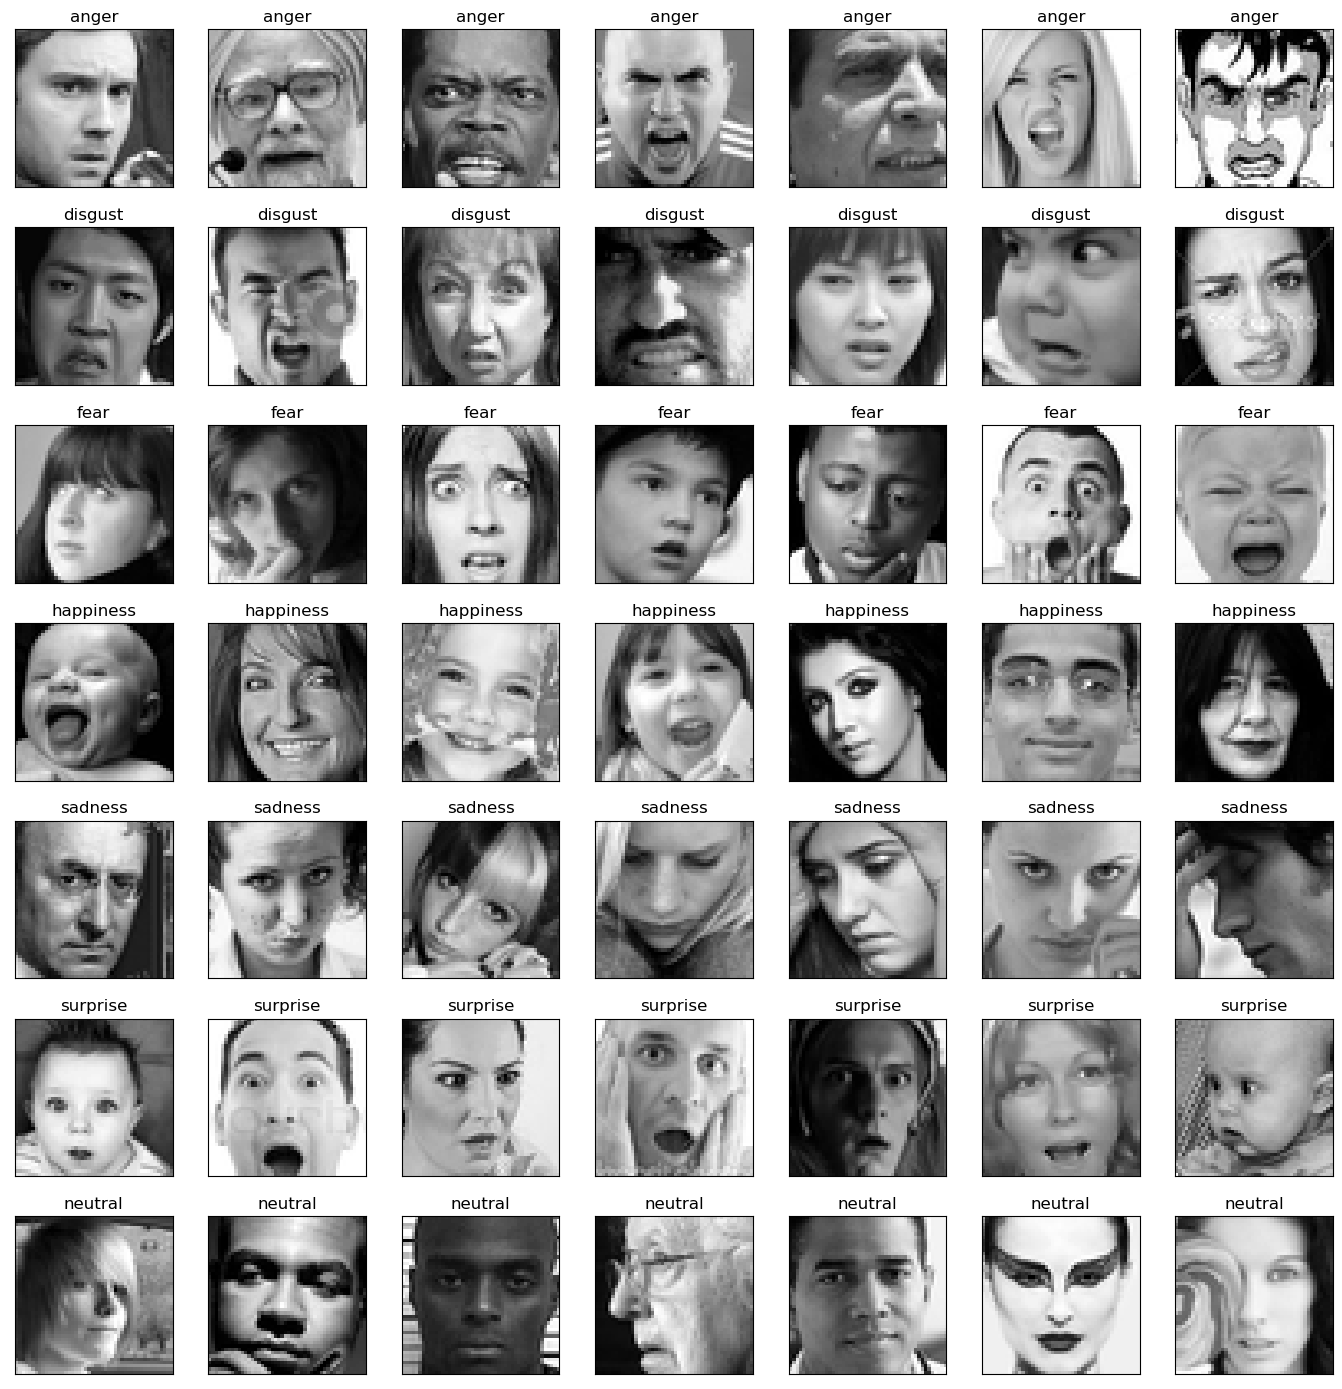

In [8]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

### Now I will make the data compatible for neural networks.

In [9]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [10]:
img_array.shape

(35887, 48, 48)

In [11]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


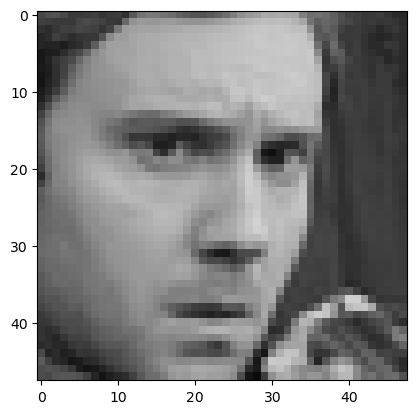

In [12]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [13]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Splitting the data into training and validation set.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [16]:
del df
del img_features
del img_labels

In [17]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [18]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [19]:
vgg = tf.keras.applications.VGG16(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [20]:
# for layer in vgg.layers:
    # layer.trainable = False

In [21]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [22]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [23]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [24]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [25]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [26]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [27]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
1009/1009 [==============================] - 51s 42ms/step - loss: 1.4295 - accuracy: 0.4444 - val_loss: 1.1920 - val_accuracy: 0.5467 - lr: 1.0000e-04
Epoch 2/25
1009/1009 [==============================] - 43s 42ms/step - loss: 1.1810 - accuracy: 0.5544 - val_loss: 1.0927 - val_accuracy: 0.5840 - lr: 1.0000e-04
Epoch 3/25
1009/1009 [==============================] - 45s 44ms/step - loss: 1.0909 - accuracy: 0.5897 - val_loss: 1.0608 - val_accuracy: 0.5996 - lr: 1.0000e-04
Epoch 4/25
1009/1009 [==============================] - 44s 43ms/step - loss: 1.0365 - accuracy: 0.6117 - val_loss: 1.0080 - val_accuracy: 0.6272 - lr: 1.0000e-04
Epoch 5/25
1009/1009 [==============================] - 44s 44ms/step - loss: 0.9945 - accuracy: 0.6271 - val_loss: 0.9608 - val_accuracy: 0.6453 - lr: 1.0000e-04
Epoch 6/25
1009/1009 [==============================] - 44s 43ms/step - loss: 0.9527 - accuracy: 0.6439 - val_loss: 0.9728 - val_accuracy: 0.6420 - lr: 1.0000e-04
Epoch 7/25
1009/1009 [

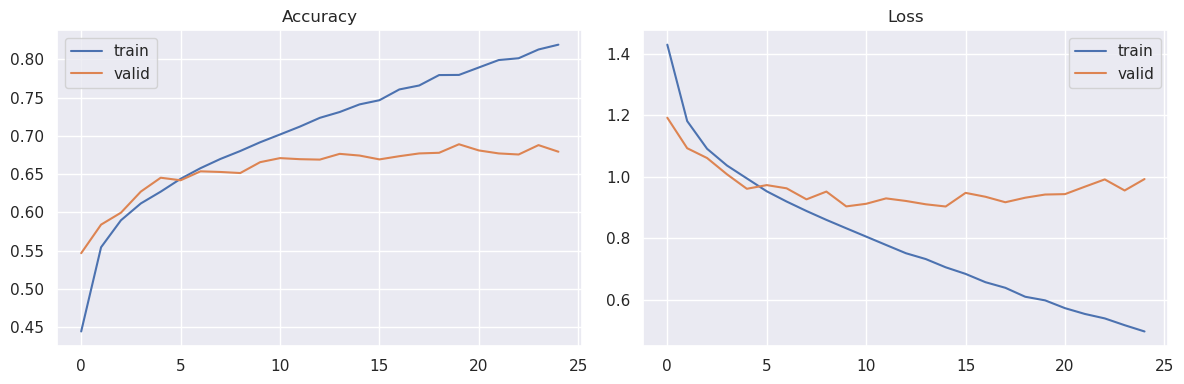

In [28]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


113/113 [==============================] - 2s 13ms/step
total wrong validation predictions: 1151


              precision    recall  f1-score   support

           0       0.56      0.64      0.60       495
           1       0.60      0.65      0.63        55
           2       0.63      0.43      0.51       512
           3       0.89      0.85      0.87       899
           4       0.54      0.59      0.57       608
           5       0.79      0.79      0.79       400
           6       0.62      0.69      0.65       620

    accuracy                           0.68      3589
   macro avg       0.66      0.66      0.66      3589
weighted avg       0.69      0.68      0.68      3589



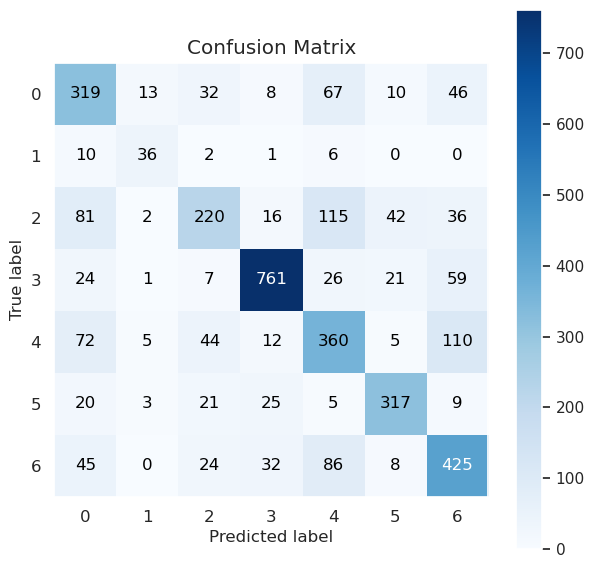

In [30]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

### The confusion matrix clearly shows that our model is doing good job on the class happy but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [31]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 16ms/step


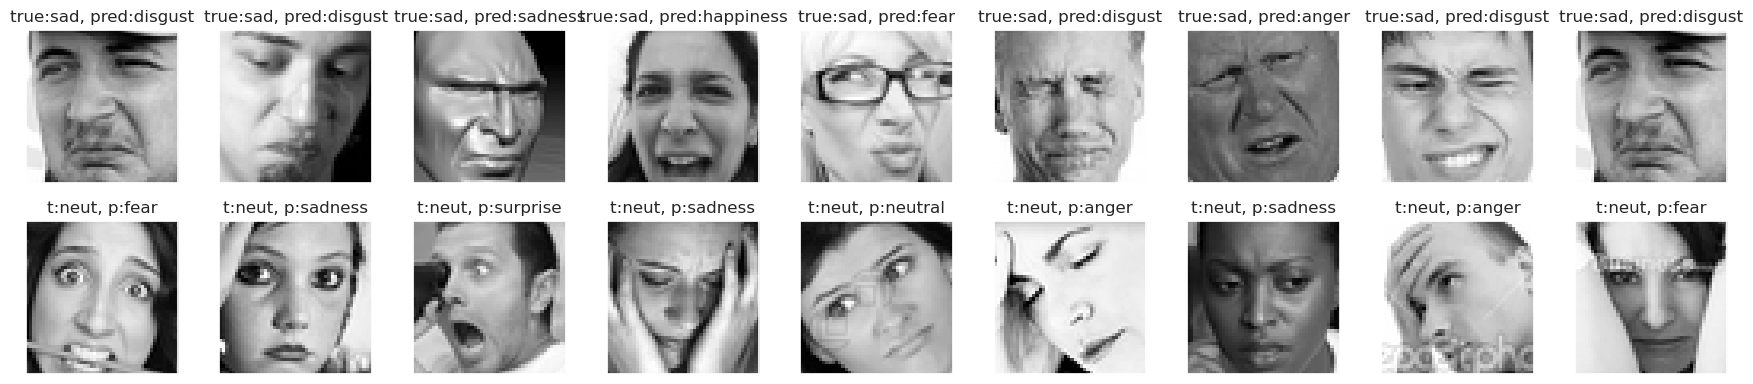

In [32]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

    ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

    ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

    pyplot.tight_layout()

In [33]:
def plot_feature_maps(model, image, max_layers_to_plot=None, max_filters_per_layer=64):
    """
    Plots the feature maps of convolutional layers in a Keras model.

    Args:
        model: Trained Keras model.
        image: Input image (H, W, C) or (1, H, W, C). Should be preprocessed
               (e.g., normalized) as expected by the model.
        max_layers_to_plot (int, optional): Maximum number of conv layers to plot.
                                            Defaults to None (plot all).
        max_filters_per_layer (int, optional): Maximum number of filters (feature maps)
                                               to plot for each layer. Defaults to 64.
    """
    print("\n--- Generating Feature Maps ---")
    # Expand dims if needed (if single image H, W, C is provided)
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
        print(f"Input image expanded to shape: {image.shape}")

    # Normalize image if needed (check if pixels are 0-255)
    # Note: Ensure the input 'image' is already preprocessed like training data.
    # This check is a safeguard but might not be necessary if input is known.
    if image.max() > 1.0:
        print("Normalizing input image (max > 1.0 detected)...")
        image = image / 255.0

    # Extract convolutional layers and their outputs
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    if not conv_layers:
        print("No convolutional layers found in the model.")
        return

    outputs = [layer.output for layer in conv_layers]
    activation_model = Model(inputs=model.input, outputs=outputs)
    print(f"Created activation model with {len(outputs)} conv layer outputs.")

    # Get feature maps by running prediction
    print("Predicting feature maps...")
    feature_maps = activation_model.predict(image)
    print(f"Obtained {len(feature_maps)} sets of feature maps.")

    # Determine which layers to plot
    layers_to_plot_indices = range(len(feature_maps))
    if max_layers_to_plot is not None:
        layers_to_plot_indices = range(min(len(feature_maps), max_layers_to_plot))
        print(f"Limiting plots to the first {len(layers_to_plot_indices)} conv layers.")

    # Plot the feature maps for selected layers
    for i in layers_to_plot_indices:
        fmap = feature_maps[i]
        layer_name = conv_layers[i].name
        num_filters = fmap.shape[-1]
        print(f"\nPlotting Layer: {layer_name} ({num_filters} filters)")

        # Limit the number of filters to plot
        filters_to_plot = min(num_filters, max_filters_per_layer)
        print(f"  (Displaying up to {filters_to_plot} filters)")


        # Determine grid size
        grid_cols = 8
        grid_rows = int(np.ceil(filters_to_plot / grid_cols))

        if grid_rows == 0 or grid_cols == 0:
            print(f"  Skipping layer {layer_name} due to zero grid size.")
            continue

        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2.2))
        fig.suptitle(f"Feature Maps - {layer_name} ({i+1})", fontsize=16, y=1.02) # Adjusted font size and y

        # Ensure axes is always a 2D array for consistent indexing
        if grid_rows == 1 and grid_cols == 1:
            axes = np.array([[axes]])
        elif grid_rows == 1:
            axes = np.array([axes])
        elif grid_cols == 1:
            axes = np.array([[ax] for ax in axes])


        for j in range(grid_rows * grid_cols):
            ax = axes[j // grid_cols, j % grid_cols]
            if j < filters_to_plot:
                try:
                    ax.imshow(fmap[0, :, :, j], cmap='viridis') # fmap[0,...] because batch size is 1
                    ax.set_title(f"F{j+1}", fontsize=8)
                except IndexError:
                    print(f"    Index error plotting filter {j+1} for layer {layer_name}")
                    ax.axis('off') # Still turn off axis if error
            ax.axis('off') # Turn off axes for all grid cells

        # Adjust layout
        plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.98]) # Adjust rect to prevent title overlap
        # plt.subplots_adjust(top=0.9) # Alternative adjustment
        plt.show()

# --- Call the plotting function ---
# Select a sample image from the validation set



--- Generating Feature Maps ---
Input image expanded to shape: (1, 48, 48, 3)
Applying VGG16 preprocessing...
Extracted 13 convolutional layers.
1/1 [==============================] - 0s 125ms/step
Feature maps computed.

Plotting Layer: block1_conv1 with 64 filters


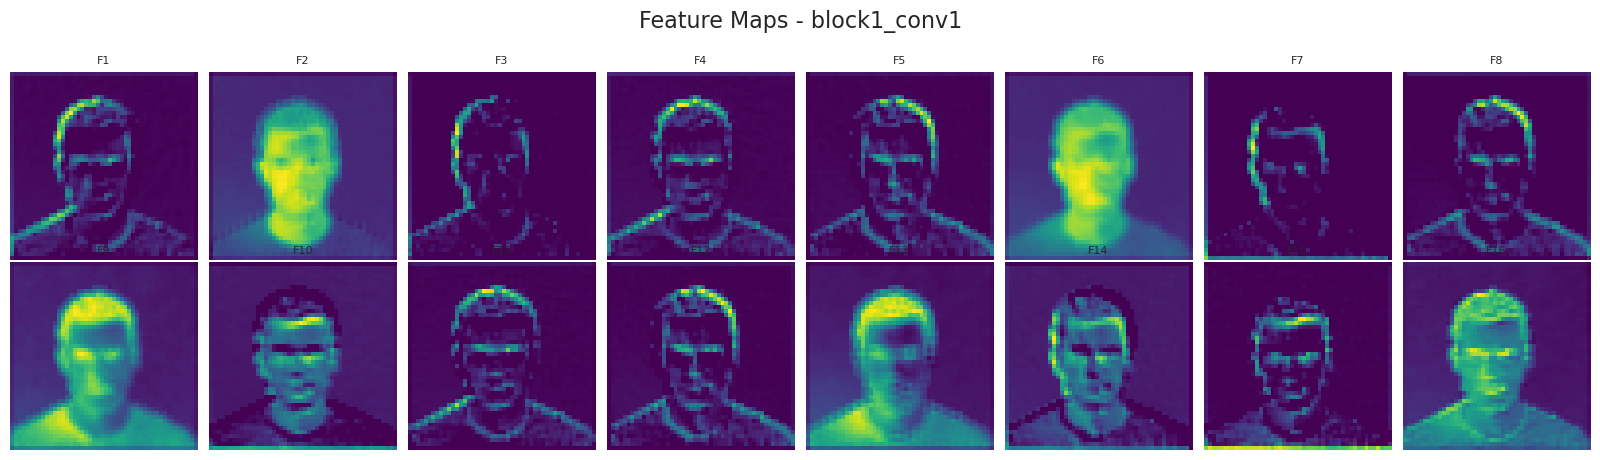


Plotting Layer: block1_conv2 with 64 filters


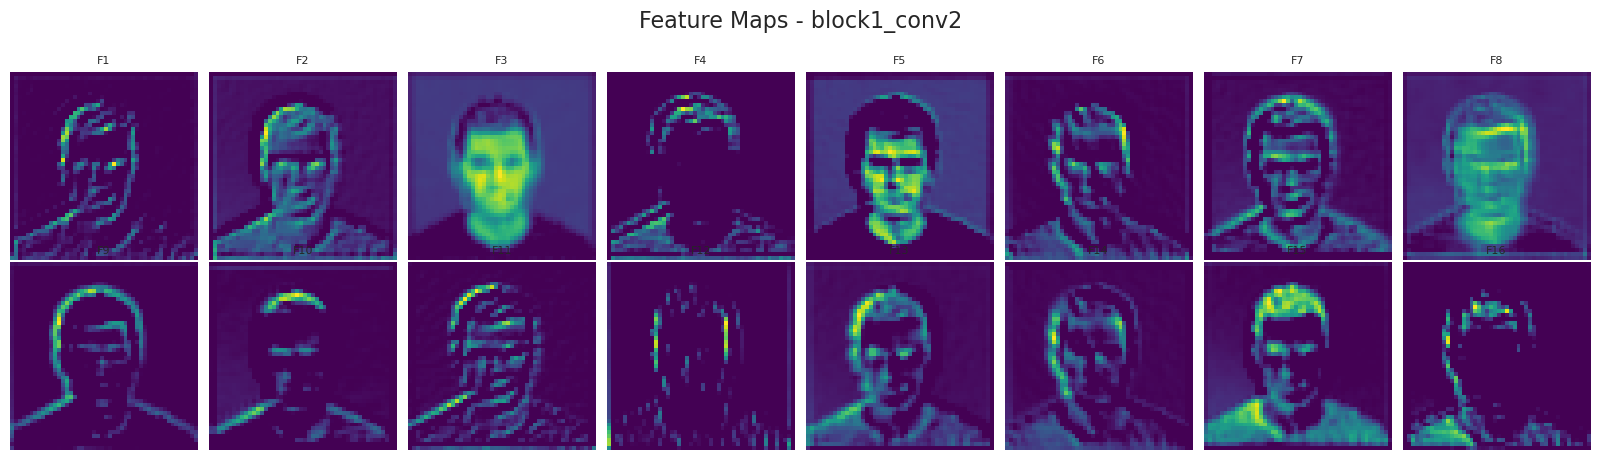


Plotting Layer: block2_conv1 with 128 filters


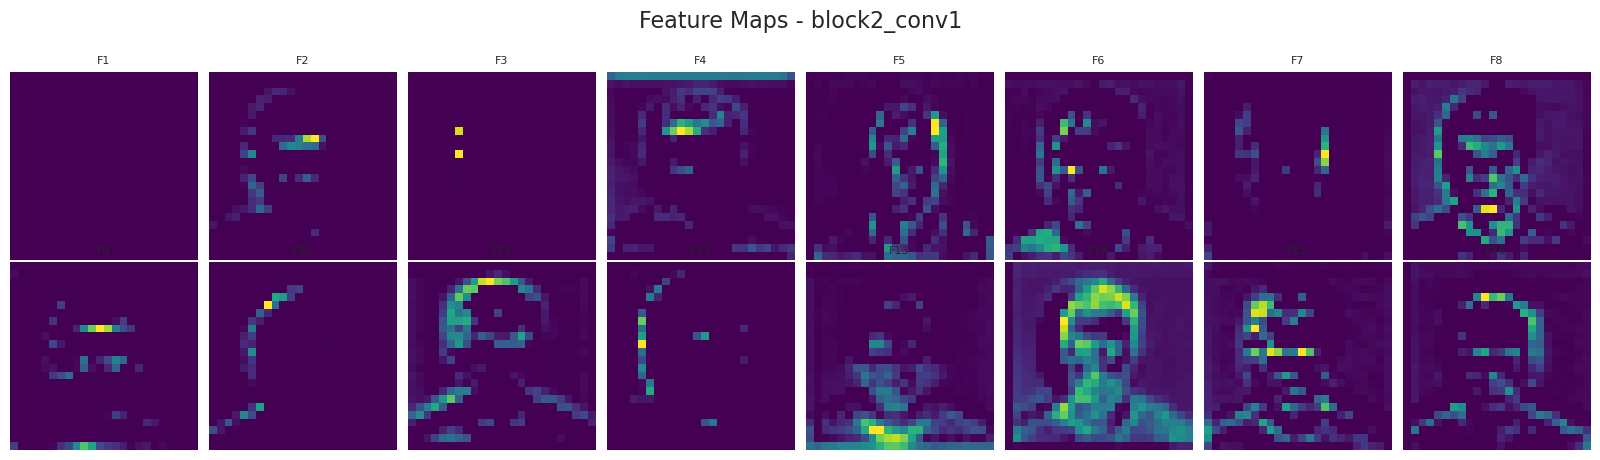


Plotting Layer: block2_conv2 with 128 filters


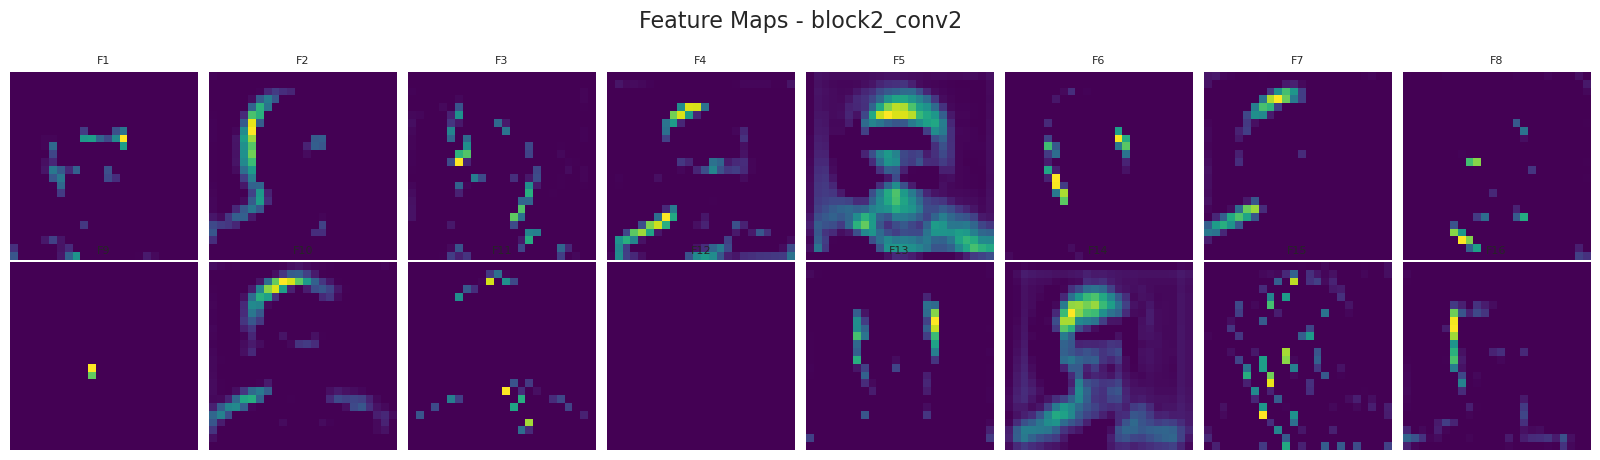


Plotting Layer: block3_conv1 with 256 filters


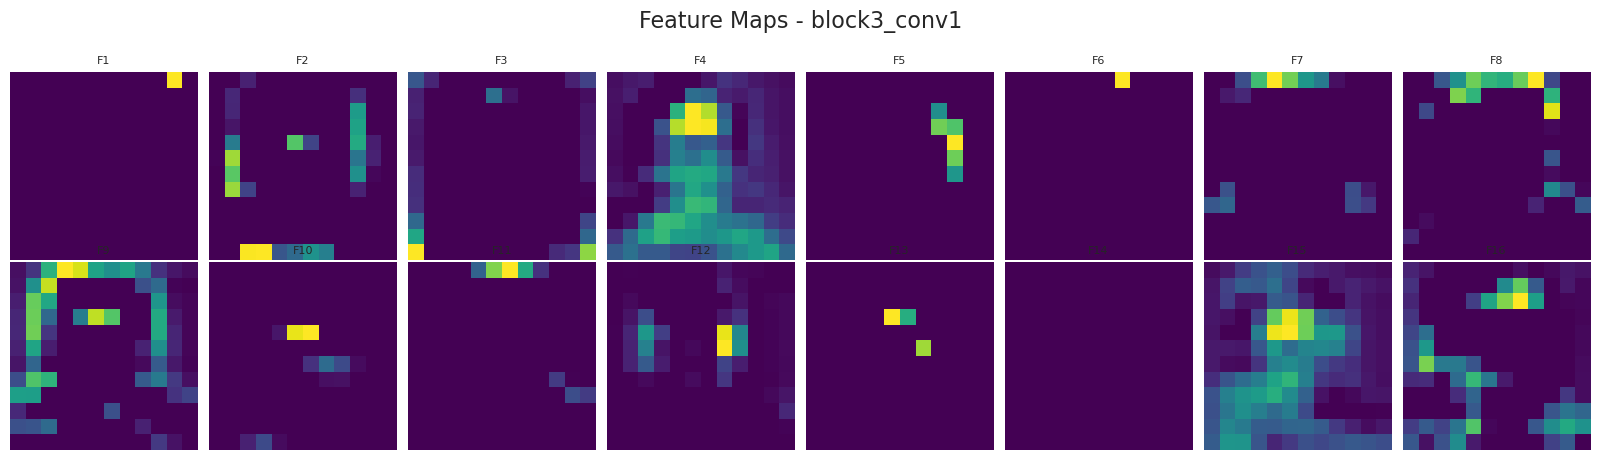

In [40]:
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2

# Load and resize image
img_path = '/kaggle/input/test-images/img-1.png'
img = keras_image.load_img(img_path, target_size=(48, 48))  # match your model input
img_array = keras_image.img_to_array(img)

# Preprocess (VGG-style)
img_array = preprocess_input(img_array)

# Call the plotting function
plot_feature_maps(model, img_array, max_layers_to_plot=5, max_filters_per_layer=16)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

def plot_feature_maps(model, image, max_layers_to_plot=None, max_filters_per_layer=64):
    """
    Plots the feature maps of convolutional layers in a VGG16 Keras model.

    Args:
        model: Trained VGG16-based Keras model.
        image: Input image as a NumPy array (H, W, C) or (1, H, W, C).
        max_layers_to_plot (int, optional): Maximum number of conv layers to plot.
        max_filters_per_layer (int, optional): Maximum number of filters per layer to plot.
    """
    print("\n--- Generating Feature Maps ---")

    # Expand dimensions if a single image is passed
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
        print(f"Input image expanded to shape: {image.shape}")

    # Apply VGG16 preprocessing (if not already preprocessed)
    if image.max() > 1.0 or image.min() < -128:
        print("Applying VGG16 preprocessing...")
        image = preprocess_input(image)

    # Extract only convolutional layers
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    if not conv_layers:
        print("No convolutional layers found.")
        return

    outputs = [layer.output for layer in conv_layers]
    activation_model = Model(inputs=model.input, outputs=outputs)

    print(f"Extracted {len(conv_layers)} convolutional layers.")
    feature_maps = activation_model.predict(image)
    print("Feature maps computed.")

    # Determine which layers to plot
    layers_to_plot = range(len(feature_maps))
    if max_layers_to_plot is not None:
        layers_to_plot = range(min(len(feature_maps), max_layers_to_plot))

    for i in layers_to_plot:
        fmap = feature_maps[i]
        layer_name = conv_layers[i].name
        num_filters = fmap.shape[-1]

        print(f"\nPlotting Layer: {layer_name} with {num_filters} filters")

        filters_to_plot = min(num_filters, max_filters_per_layer)
        grid_cols = 8
        grid_rows = int(np.ceil(filters_to_plot / grid_cols))

        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2.2))
        fig.suptitle(f"Feature Maps - {layer_name}", fontsize=16, y=1.02)

        axes = np.array(axes).reshape(grid_rows, grid_cols)

        for j in range(grid_rows * grid_cols):
            ax = axes[j // grid_cols, j % grid_cols]
            if j < filters_to_plot:
                ax.imshow(fmap[0, :, :, j], cmap='viridis')
                ax.set_title(f"F{j+1}", fontsize=8)
            ax.axis('off')

        plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.98])
        plt.show()


1/1 [==============================] - 0s 118ms/step
The predicted emotion is: anger


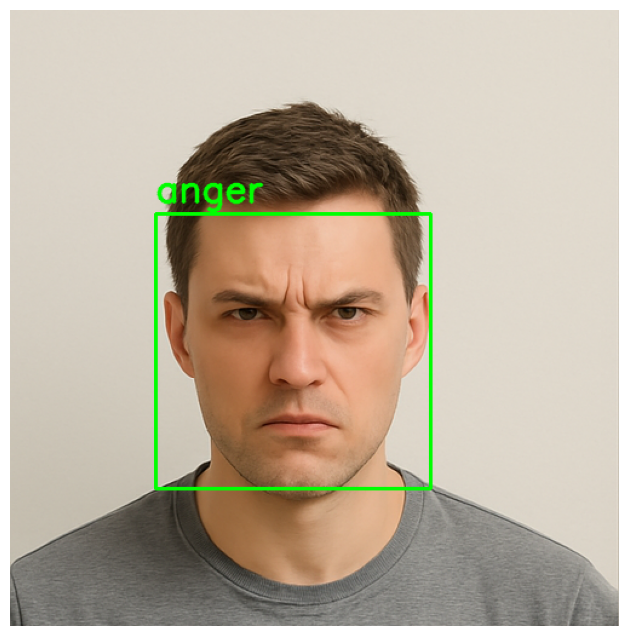

In [45]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Make sure this path is correct

# Emotion labels (adjust according to your training)
emotion_label_to_text =  {0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'}

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the test image
img_path = '/kaggle/input/test-images/img-1.png'  # Update if needed
img = cv2.imread(img_path)

# Convert to grayscale for face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through each face
for (x, y, w, h) in faces:
    # Extract face region from original image
    face = img[y:y+h, x:x+w]

    # Resize to match model input size
    face_resized = cv2.resize(face, (48, 48))  # Still in BGR
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB
    face_normalized = face_rgb / 255.0  # Normalize

    # Add batch dimension
    face_array = np.expand_dims(face_normalized, axis=0)  # Shape: (1, 48, 48, 3)

    # Make prediction
    prediction = model.predict(face_array)
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw bounding box and label
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Show final result
print(f"The predicted emotion is: {emotion}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert full image to RGB for display

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 120ms/step


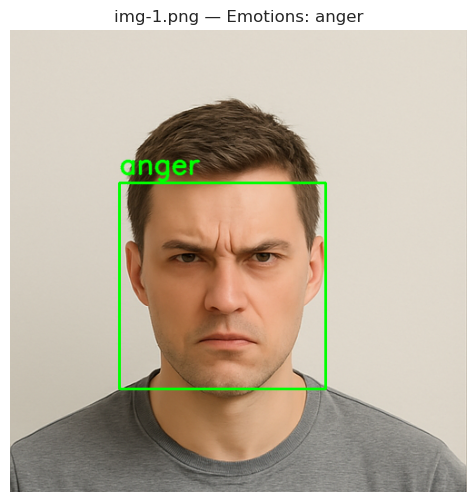

1/1 [==============================] - 0s 24ms/step


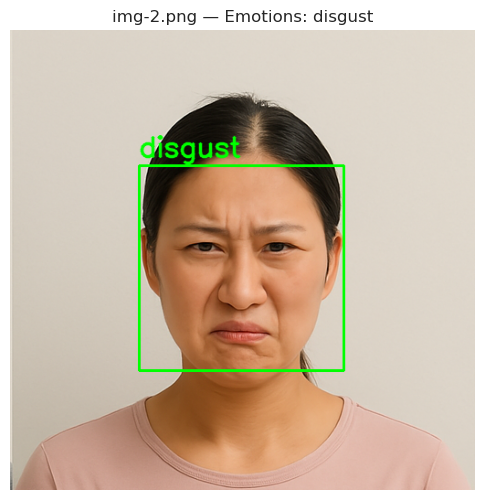

1/1 [==============================] - 0s 17ms/step


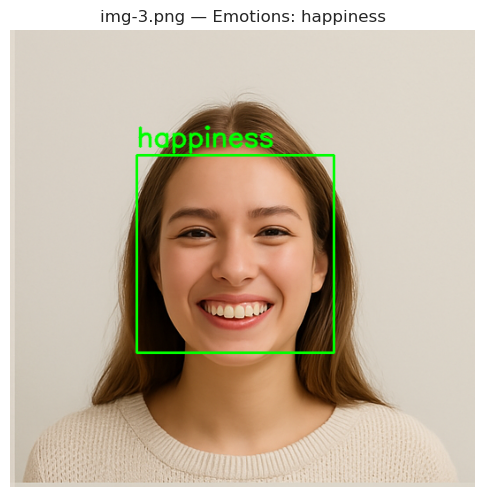

1/1 [==============================] - 0s 18ms/step


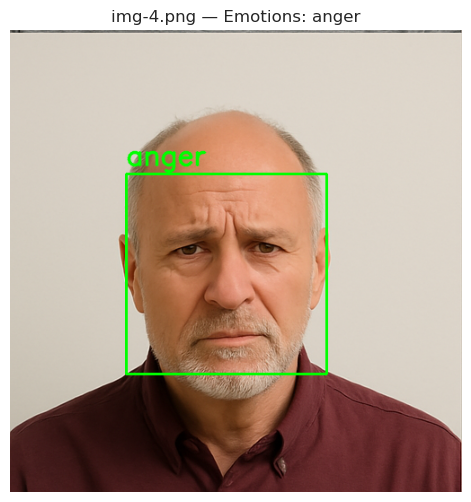

1/1 [==============================] - 0s 17ms/step


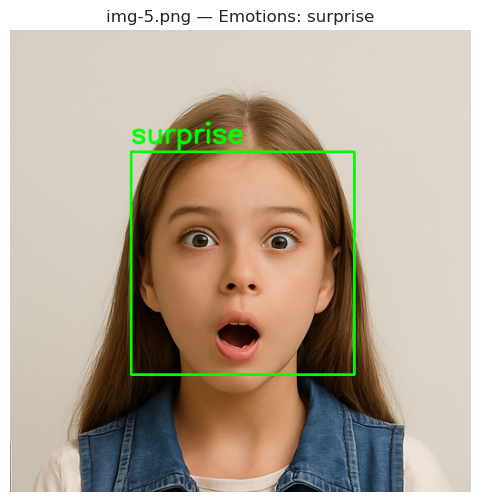

1/1 [==============================] - 0s 18ms/step


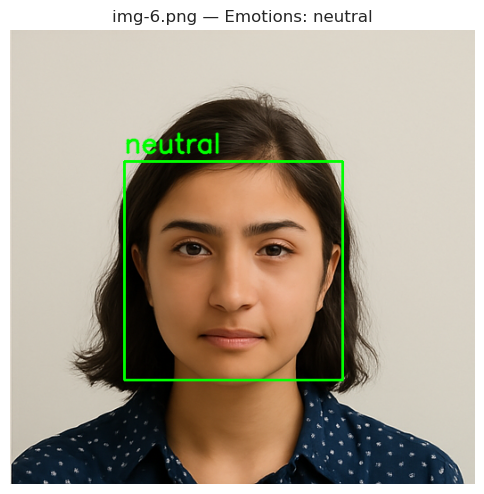

In [46]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Make sure this path is correct

# Emotion labels
emotion_label_to_text = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Process all 6 test images
for i in range(1, 7):
    img_path = f'/kaggle/input/test-images/img-{i}.png'
    img = cv2.imread(img_path)

    if img is None:
        print(f"Image not found at {img_path}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    emotions_detected = []

    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (48, 48))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        face_normalized = face_rgb / 255.0
        face_array = np.expand_dims(face_normalized, axis=0)

        prediction = model.predict(face_array)
        predicted_class = np.argmax(prediction)
        emotion = emotion_label_to_text[predicted_class]
        emotions_detected.append(emotion)

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert image for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"img-{i}.png — Emotions: {', '.join(emotions_detected) if emotions_detected else 'No face detected'}")
    plt.axis('off')
    plt.show()


In [42]:
model.save('/kaggle/working/model.h5')  # Saves the full model (architecture + weights + optimizer)
